🛠️ Step 1: Web Scraping NSE Option Chain

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import mysql.connector
from mysql.connector import Error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

# NSE API URL for Nifty 50 Option Chain
URL = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"

# Headers to bypass NSE restrictions
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.nseindia.com/option-chain"
}

# Start a session to persist cookies
session = requests.Session()

# Fetch data
response = session.get(URL, headers=HEADERS)
data = response.json()

# Extract option chain data
option_data = data['records']['data']

# Convert JSON data into a structured DataFrame
df = pd.json_normalize(option_data)

# Display the first few rows
print(df.head())


   strikePrice   expiryDate  PE.strikePrice PE.expiryDate PE.underlying  \
0        12000  31-Dec-2026         12000.0   31-Dec-2026         NIFTY   
1        13000  24-Dec-2025         13000.0   24-Dec-2025         NIFTY   
2        13000  31-Dec-2026         13000.0   31-Dec-2026         NIFTY   
3        14000  26-Jun-2025         14000.0   26-Jun-2025         NIFTY   
4        14000  25-Jun-2026         14000.0   25-Jun-2026         NIFTY   

                     PE.identifier  PE.openInterest  PE.changeinOpenInterest  \
0  OPTIDXNIFTY31-12-2026PE12000.00        13.666667                      0.0   
1  OPTIDXNIFTY24-12-2025PE13000.00        50.000000                      0.0   
2  OPTIDXNIFTY31-12-2026PE13000.00        27.000000                      0.0   
3  OPTIDXNIFTY26-06-2025PE14000.00       130.666667                      0.0   
4  OPTIDXNIFTY25-06-2026PE14000.00        14.333333                      0.0   

   PE.pchangeinOpenInterest  PE.totalTradedVolume  ...  CE.lastPrice

In [241]:
df.head()

,strikePrice,expiryDate,PE.strikePrice,PE.expiryDate,PE.underlying,PE.identifier,PE.openInterest,PE.changeinOpenInterest,PE.pchangeinOpenInterest,PE.totalTradedVolume,...,CE.lastPrice,CE.change,CE.pChange,CE.totalBuyQuantity,CE.totalSellQuantity,CE.bidQty,CE.bidprice,CE.askQty,CE.askPrice,CE.underlyingValue
0,12000,25-Jun-2026,12000.0,25-Jun-2026,NIFTY,OPTIDXNIFTY25-06-2026PE12000.00,6.333333,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12000,31-Dec-2026,12000.0,31-Dec-2026,NIFTY,OPTIDXNIFTY31-12-2026PE12000.00,13.666667,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13000,24-Dec-2025,13000.0,24-Dec-2025,NIFTY,OPTIDXNIFTY24-12-2025PE13000.00,50.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13000,31-Dec-2026,13000.0,31-Dec-2026,NIFTY,OPTIDXNIFTY31-12-2026PE13000.00,27.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14000,26-Jun-2025,14000.0,26-Jun-2025,NIFTY,OPTIDXNIFTY26-06-2025PE14000.00,110.666667,1.0,0.911854,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


🛠️ Step 2: Data Cleaning & Preprocessing
We’ll clean the data by removing unnecessary columns and converting types.

In [244]:
# Selecting required columns

columns = [
    "CE.openInterest", "CE.changeinOpenInterest", "CE.totalTradedVolume", "CE.impliedVolatility", "CE.lastPrice",
    "strikePrice", 'expiryDate',
    "PE.openInterest", "PE.changeinOpenInterest", "PE.totalTradedVolume", "PE.impliedVolatility", "PE.lastPrice"
]


df = df[columns]

# Renaming columns for clarity

df.columns = [
    "CE_OI", "CE_Change_OI", "CE_Volume", "CE_IV", "CE_LTP",
    "Strike_Price",'Expiry_date',
    "PE_OI", "PE_Change_OI", "PE_Volume", "PE_IV", "PE_LTP"
]


# Display cleaned DataFrame
print(df.head())


   CE_OI  CE_Change_OI  CE_Volume  CE_IV  CE_LTP  Strike_Price  Expiry_date  \
0    NaN           NaN        NaN    NaN     NaN         12000  25-Jun-2026   
1    NaN           NaN        NaN    NaN     NaN         12000  31-Dec-2026   
2    NaN           NaN        NaN    NaN     NaN         13000  24-Dec-2025   
3    NaN           NaN        NaN    NaN     NaN         13000  31-Dec-2026   
4    NaN           NaN        NaN    NaN     NaN         14000  26-Jun-2025   

        PE_OI  PE_Change_OI  PE_Volume  PE_IV  PE_LTP  
0    6.333333           0.0        0.0   0.00    0.00  
1   13.666667           0.0        0.0   0.00    0.00  
2   50.000000           0.0        0.0   0.00    0.00  
3   27.000000           0.0        0.0   0.00    0.00  
4  110.666667           1.0        4.0  41.19    4.95  


In [246]:
df.tail()

,CE_OI,CE_Change_OI,CE_Volume,CE_IV,CE_LTP,Strike_Price,Expiry_date,PE_OI,PE_Change_OI,PE_Volume,PE_IV,PE_LTP
829,26820.333333,-957.0,55116.0,83.78,0.40,30000,27-Mar-2025,346.666667,-26.333333,38.0,0.0,6291.0
830,2231.000000,94.0,297.0,18.15,8.80,30000,26-Jun-2025,NaN,NaN,NaN,NaN,NaN
831,913.000000,18.0,304.0,12.03,68.75,30000,24-Dec-2025,11.000000,0.000000,0.0,0.0,0.0
832,117115.333333,28491.0,181415.0,91.68,0.30,31000,27-Mar-2025,236.333333,-10.000000,13.0,0.0,7290.0
833,753.333333,2.0,79.0,13.01,50.00,31000,24-Dec-2025,NaN,NaN,NaN,NaN,NaN


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CE_OI         694 non-null    float64
 1   CE_Change_OI  694 non-null    float64
 2   CE_Volume     694 non-null    float64
 3   CE_IV         694 non-null    float64
 4   CE_LTP        694 non-null    float64
 5   Strike_Price  834 non-null    int64  
 6   Expiry_date   834 non-null    object 
 7   PE_OI         800 non-null    float64
 8   PE_Change_OI  800 non-null    float64
 9   PE_Volume     800 non-null    float64
 10  PE_IV         800 non-null    float64
 11  PE_LTP        800 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 78.3+ KB


In [250]:
df.describe()

,CE_OI,CE_Change_OI,CE_Volume,CE_IV,CE_LTP,Strike_Price,PE_OI,PE_Change_OI,PE_Volume,PE_IV,PE_LTP
count,694.000000,694.000000,6.940000e+02,694.000000,694.000000,834.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000
mean,4860.800672,547.643612,5.268184e+04,11.797925,536.057853,22840.767386,5017.093750,742.118333,3.641575e+04,13.433863,251.593750
std,15924.027448,5149.555411,2.660359e+05,14.309585,879.555157,2405.484407,16824.602571,6596.217015,1.736539e+05,12.889463,633.070796
min,0.000000,-48076.000000,0.000000e+00,0.000000,0.000000,12000.000000,0.000000,-31370.666667,0.000000e+00,0.000000,0.000000
25%,9.000000,0.000000,0.000000e+00,0.000000,0.000000,21550.000000,5.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,104.500000,0.000000,7.550000e+01,11.435000,91.600000,22950.000000,99.000000,0.000000,1.000000e+02,14.030000,18.350000
75%,2470.000000,61.250000,2.299750e+03,15.430000,807.837500,24250.000000,1664.000000,93.250000,2.467000e+03,19.025000,201.975000
max,169500.666667,50034.000000,2.655353e+06,122.660000,6770.000000,31000.000000,185962.000000,105850.000000,2.436705e+06,93.760000,7290.000000


In [252]:
df.fillna(0, inplace=True)  # Replace NaN with 0 (Alternative: df.dropna())

In [254]:
df.head()

,CE_OI,CE_Change_OI,CE_Volume,CE_IV,CE_LTP,Strike_Price,Expiry_date,PE_OI,PE_Change_OI,PE_Volume,PE_IV,PE_LTP
0,0.0,0.0,0.0,0.0,0.0,12000,25-Jun-2026,6.333333,0.0,0.0,0.00,0.00
1,0.0,0.0,0.0,0.0,0.0,12000,31-Dec-2026,13.666667,0.0,0.0,0.00,0.00
2,0.0,0.0,0.0,0.0,0.0,13000,24-Dec-2025,50.000000,0.0,0.0,0.00,0.00
3,0.0,0.0,0.0,0.0,0.0,13000,31-Dec-2026,27.000000,0.0,0.0,0.00,0.00
4,0.0,0.0,0.0,0.0,0.0,14000,26-Jun-2025,110.666667,1.0,4.0,41.19,4.95


In [256]:
import numpy as np

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data within bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply IQR outlier removal to key numeric columns
columns_to_clean = ["CE_IV", "PE_IV", "CE_OI", "PE_OI"]
for col in columns_to_clean:
    df = remove_outliers_iqr(df, col)

# Display cleaned data
print(df.describe())


             CE_OI  CE_Change_OI     CE_Volume       CE_IV       CE_LTP  \
count   550.000000    550.000000    550.000000  550.000000   550.000000   
mean    194.955152     56.976364   1148.121818    5.419273   226.130364   
std     500.032996    264.535179   4209.546677    7.280762   537.160643   
min       0.000000  -2038.000000      0.000000    0.000000     0.000000   
25%       0.000000      0.000000      0.000000    0.000000     0.000000   
50%       6.000000      0.000000      0.000000    0.000000     0.000000   
75%      79.000000      0.000000     87.000000   11.770000   146.625000   
max    3052.000000   1984.000000  32655.000000   35.530000  6770.000000   

       Strike_Price       PE_OI  PE_Change_OI    PE_Volume       PE_IV  \
count    550.000000  550.000000    550.000000   550.000000  550.000000   
mean   22775.090909   90.714545     20.120000   172.187273    9.089182   
std     2670.058889  162.504181     87.041477   378.537161    9.768337   
min    12000.000000    0.000

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 0 to 833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CE_OI         550 non-null    float64
 1   CE_Change_OI  550 non-null    float64
 2   CE_Volume     550 non-null    float64
 3   CE_IV         550 non-null    float64
 4   CE_LTP        550 non-null    float64
 5   Strike_Price  550 non-null    int64  
 6   Expiry_date   550 non-null    object 
 7   PE_OI         550 non-null    float64
 8   PE_Change_OI  550 non-null    float64
 9   PE_Volume     550 non-null    float64
 10  PE_IV         550 non-null    float64
 11  PE_LTP        550 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 55.9+ KB


In [260]:
# Convert ExpiryDate to datetime
df["Expiry_date"] = pd.to_datetime(df["Expiry_date"], format="%d-%b-%Y")

In [262]:
df.head()

,CE_OI,CE_Change_OI,CE_Volume,CE_IV,CE_LTP,Strike_Price,Expiry_date,PE_OI,PE_Change_OI,PE_Volume,PE_IV,PE_LTP
0,0.0,0.0,0.0,0.0,0.0,12000,2026-06-25,6.333333,0.0,0.0,0.00,0.00
1,0.0,0.0,0.0,0.0,0.0,12000,2026-12-31,13.666667,0.0,0.0,0.00,0.00
2,0.0,0.0,0.0,0.0,0.0,13000,2025-12-24,50.000000,0.0,0.0,0.00,0.00
3,0.0,0.0,0.0,0.0,0.0,13000,2026-12-31,27.000000,0.0,0.0,0.00,0.00
4,0.0,0.0,0.0,0.0,0.0,14000,2025-06-26,110.666667,1.0,4.0,41.19,4.95


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 0 to 833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CE_OI         550 non-null    float64       
 1   CE_Change_OI  550 non-null    float64       
 2   CE_Volume     550 non-null    float64       
 3   CE_IV         550 non-null    float64       
 4   CE_LTP        550 non-null    float64       
 5   Strike_Price  550 non-null    int64         
 6   Expiry_date   550 non-null    datetime64[ns]
 7   PE_OI         550 non-null    float64       
 8   PE_Change_OI  550 non-null    float64       
 9   PE_Volume     550 non-null    float64       
 10  PE_IV         550 non-null    float64       
 11  PE_LTP        550 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 55.9 KB


In [266]:
# MySQL connection details
db_config = {
    "host": "127.0.0.1",  # Change to your MySQL server
    "user": "root",  # Your MySQL username
    "password": "Nik_MySQL2024",  # Your MySQL password
    "database": "nse_option_chain"  # Use the correct database name
}

def connect_to_mysql():
    """Establish connection to MySQL"""
    try:
        conn = mysql.connector.connect(**db_config)
        if conn.is_connected():
            print("✅ Connected to MySQL")
        return conn
    except Error as e:
        print(f"❌ Error: {e}")
        return None

In [268]:
def insert_option_chain_data(df):
    """Insert option chain data into MySQL with expiry date"""
    conn = connect_to_mysql()
    if conn is None:
        return

    cursor = conn.cursor()

    insert_query = """
    INSERT IGNORE INTO option_chain 
    (timestamp, expiry_date, CE_OI, CE_Change_OI, CE_IV, CE_LTP, CE_Volume, Strike_Price, PE_LTP, PE_IV, PE_OI, PE_Change_OI, PE_Volume)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

    fetch_time = datetime.now()

    for _, row in df.iterrows():
        cursor.execute(insert_query, (
            fetch_time, row['Expiry_date'], row['CE_OI'], row['CE_Change_OI'], row['CE_IV'], row['CE_LTP'], row['CE_Volume'],
            row['Strike_Price'], row['PE_LTP'], row['PE_IV'], row['PE_OI'], row['PE_Change_OI'], row['PE_Volume']
        ))

    conn.commit()
    # ✅ Get the actual row count from the database
    cursor.execute("SELECT COUNT(*) FROM option_chain")
    total_rows = cursor.fetchone()[0]

    print(f"✅ {total_rows} rows present in the database after insertion.")

    cursor.close()
    conn.close()


In [270]:
insert_option_chain_data(df)

✅ Connected to MySQL
✅ 550 rows present in the database after insertion.


🛠️ Step 4: Option Chain Analysis

We will calculate Open Interest (OI), Max Pain, and Implied Volatility (IV) Trends.

🔹 Max Pain Calculation
Max Pain Theory states that option sellers (who write options) suffer the least when a stock closes at a particular price.

In [274]:
# Calculate Max Pain
df['Total_OI'] = df['CE_OI'] + df['PE_OI']
max_pain_strike = df.loc[df['Total_OI'].idxmax(), 'Strike_Price']

print(f"Max Pain Strike Price: {max_pain_strike}")

Max Pain Strike Price: 24400


✔ This gives us the strike price where the total OI is maximum.

In [277]:
# Count of unique expiry dates
print("Unique Expiry Dates:\n", df["Expiry_date"].value_counts())

Unique Expiry Dates:
 Expiry_date
2025-04-17    90
2025-05-29    77
2025-04-09    75
2025-04-30    71
2025-04-24    56
2025-04-03    38
2026-12-31    18
2026-06-25    15
2027-12-30    14
2029-12-27    13
2029-06-28    13
2028-12-28    13
2028-06-29    13
2027-06-24    13
2025-12-24    10
2025-09-25     8
2025-03-27     7
2025-06-26     6
Name: count, dtype: int64


🛠️ Step 5: Python Visualizations
🔹 Open Interest Chart

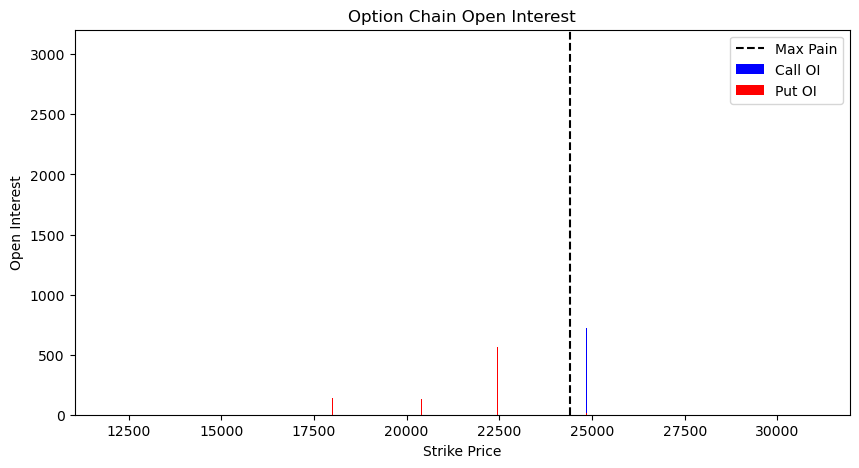

In [280]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(df['Strike_Price'], df['CE_OI'], color='blue', label="Call OI")
plt.bar(df['Strike_Price'], df['PE_OI'], color='red', label="Put OI")
plt.axvline(max_pain_strike, color='black', linestyle='dashed', label='Max Pain')

plt.xlabel("Strike Price")
plt.ylabel("Open Interest")
plt.title("Option Chain Open Interest")
plt.legend()
plt.show()


✔ This chart shows the distribution of Call & Put OI across strike prices.

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 0 to 833
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CE_OI         550 non-null    float64       
 1   CE_Change_OI  550 non-null    float64       
 2   CE_Volume     550 non-null    float64       
 3   CE_IV         550 non-null    float64       
 4   CE_LTP        550 non-null    float64       
 5   Strike_Price  550 non-null    int64         
 6   Expiry_date   550 non-null    datetime64[ns]
 7   PE_OI         550 non-null    float64       
 8   PE_Change_OI  550 non-null    float64       
 9   PE_Volume     550 non-null    float64       
 10  PE_IV         550 non-null    float64       
 11  PE_LTP        550 non-null    float64       
 12  Total_OI      550 non-null    float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 76.3 KB


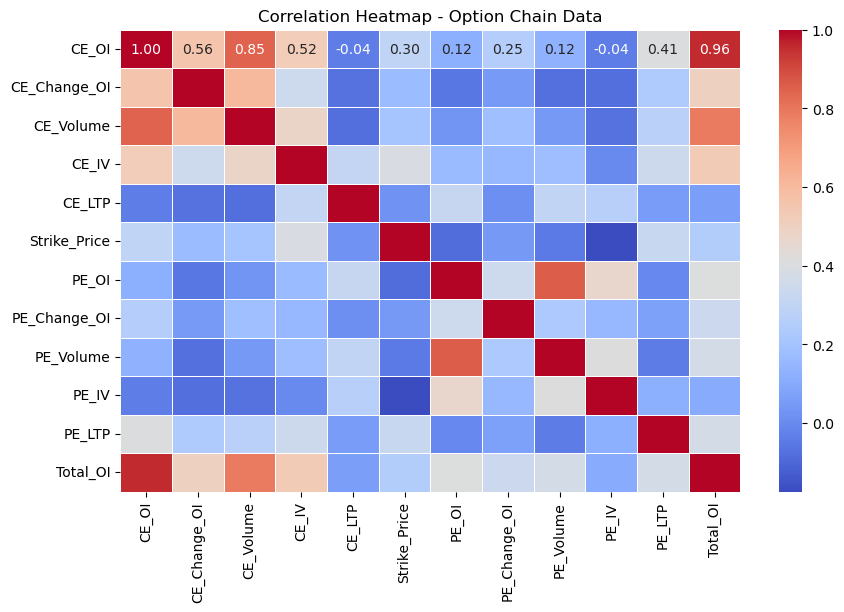

In [285]:
# Correlation analysis
# ✅ Drop non-numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=['number'])  # Keep only numeric columns
# ✅ Compute Correlation Matrix
corr_matrix = numeric_df.corr()

# ✅ Step 2: Generate Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# ✅ Step 3: Customize and Show Plot
plt.title("Correlation Heatmap - Option Chain Data")
plt.show()


📊 Interpretation of the Heatmap
Dark Red (+1.0) → Strong positive correlation

Dark Blue (-1.0) → Strong negative correlation

Near 0 (White/Gray) → No correlation

🔹 Key Insights to Look For:
✔ Does IV (Implied Volatility) correlate with Open Interest (OI)?
✔ How does LTP (Last Traded Price) change with Strike Price?
✔ Are CE (Call) and PE (Put) metrics inversely related?

1️⃣ Open Interest (OI) Analysis
Highest Open Interest Levels → Identify support/resistance levels.

Increase in OI → Possible trend continuation.

Decrease in OI → Possible trend reversal.

In [289]:
# ✅ Find the Strike Price with the highest OI for Calls & Puts
max_ce_oi = df.loc[df["CE_OI"].idxmax(), ["Strike_Price", "CE_OI"]]
max_pe_oi = df.loc[df["PE_OI"].idxmax(), ["Strike_Price", "PE_OI"]]

print("Max Call OI Strike Price:", max_ce_oi)
print("Max Put OI Strike Price:", max_pe_oi)


Max Call OI Strike Price: Strike_Price     24400
CE_OI           3052.0
Name: 644, dtype: object
Max Put OI Strike Price: Strike_Price    21900
PE_OI           678.0
Name: 263, dtype: object


📌 Interpretation:

If CE OI > PE OI at a Strike Price, traders are betting the price will go above it.

If PE OI > CE OI, traders expect the price to fall below that level.

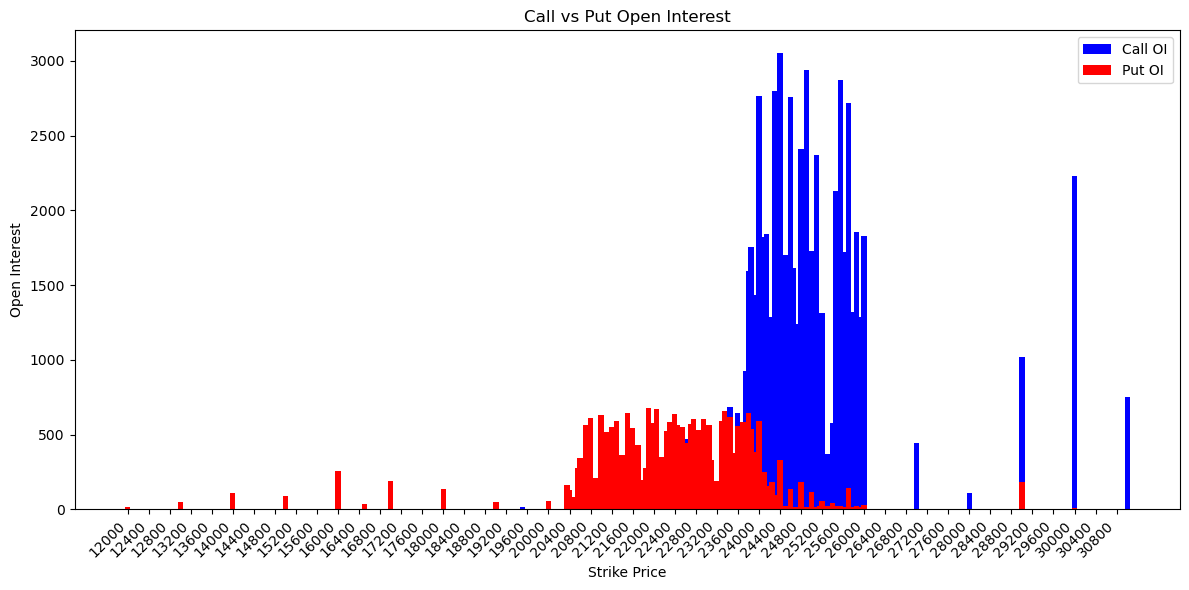

In [313]:

# Ensure Strike_Price is numeric
df["Strike_Price"] = pd.to_numeric(df["Strike_Price"], errors="coerce")

# Sort data by Strike Price
df = df.sort_values(by="Strike_Price")

plt.figure(figsize=(12, 6))
plt.bar(df["Strike_Price"], df["CE_OI"], color="blue", label="Call OI", width=100)
plt.bar(df["Strike_Price"], df["PE_OI"], color="red", label="Put OI", width=100)

plt.xlabel("Strike Price")
plt.ylabel("Open Interest")
plt.title("Call vs Put Open Interest")

# Define x-ticks at regular intervals
min_price = df["Strike_Price"].min()
max_price = df["Strike_Price"].max()
tick_positions = np.arange(min_price, max_price + 1, 400)  # Adjust interval as needed

plt.xticks(tick_positions, rotation=45, ha="right")

plt.legend()
plt.tight_layout()
plt.show()


2️⃣ Put-Call Ratio (PCR) Analysis
PCR helps determine market sentiment:

PCR > 1: Bearish sentiment (More puts than calls).

PCR < 1: Bullish sentiment (More calls than puts).

In [317]:
# ✅ Calculate PCR at each strike price
df["PCR"] = df["PE_OI"] / df["CE_OI"].replace(0, 1)  # Avoid division by zero

# ✅ Overall PCR for the entire Option Chain
overall_pcr = df["PE_OI"].sum() / df["CE_OI"].sum()
print("Overall Put-Call Ratio (PCR):", overall_pcr)


Overall Put-Call Ratio (PCR): 0.4653098148447506


📌 Interpretation:

PCR > 1.2 → Very Bearish Market

PCR < 0.8 → Very Bullish Market

PCR Between 0.8 - 1.2 → Neutral Market

C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


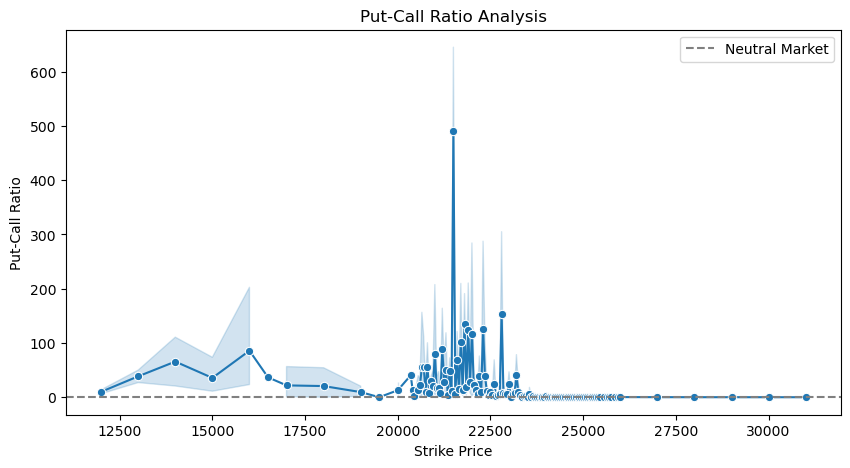

In [320]:
# Put-Call Ratio (PCR)
df['PCR'] = df['PE_OI'] / df['CE_OI'].replace(0, 1)
plt.figure(figsize=(10,5))
sns.lineplot(x=df['Strike_Price'], y=df['PCR'], marker='o')
plt.xlabel("Strike Price")
plt.ylabel("Put-Call Ratio")
plt.title("Put-Call Ratio Analysis")
plt.axhline(1, linestyle='--', color='grey', label='Neutral Market')
plt.legend()
plt.show()

3️⃣ Change in Open Interest (OI) - Trend Confirmation
High OI + Increasing OI → Strong trend.

High OI + Decreasing OI → Reversal incoming.

In [323]:
# ✅ Identify strike prices where OI has increased significantly
df["CE_OI_Change_Percentage"] = (df["CE_Change_OI"] / df["CE_OI"].replace(0, 1)) * 100
df["PE_OI_Change_Percentage"] = (df["PE_Change_OI"] / df["PE_OI"].replace(0, 1)) * 100

# ✅ Top 5 increasing/decreasing OI
top_ce_increase = df.nlargest(5, "CE_OI_Change_Percentage")[["Strike_Price", "CE_OI_Change_Percentage"]]
top_ce_decrease = df.nsmallest(5, "CE_OI_Change_Percentage")[["Strike_Price", "CE_OI_Change_Percentage"]]

print("Top 5 Increasing Call OI:\n", top_ce_increase)
print("Top 5 Decreasing Call OI:\n", top_ce_decrease)


Top 5 Increasing Call OI:
      Strike_Price  CE_OI_Change_Percentage
466         23200                    100.0
473         23250                    100.0
617         24200                    100.0
622         24250                    100.0
636         24350                    100.0
Top 5 Decreasing Call OI:
      Strike_Price  CE_OI_Change_Percentage
516         23550              -230.000000
667         24550              -211.764706
450         23100              -185.714286
615         24200              -172.839506
547         23800              -127.614277


In [327]:
print(df['Strike_Price'].unique())  # Check unique values
print(df['Strike_Price'].dtype)  # Check data type

[12000 13000 14000 15000 16000 16500 17000 18000 19000 19500 20000 20350
 20400 20450 20550 20600 20650 20700 20750 20800 20850 20900 20950 21000
 21050 21100 21150 21200 21250 21300 21350 21400 21450 21500 21550 21600
 21650 21700 21750 21800 21850 21900 21950 22000 22050 22100 22150 22200
 22250 22300 22350 22400 22450 22500 22550 22600 22650 22700 22750 22800
 22850 22900 22950 23000 23050 23100 23150 23200 23250 23300 23350 23400
 23450 23500 23550 23600 23650 23700 23750 23800 23850 23900 23950 24000
 24050 24100 24150 24200 24250 24300 24350 24400 24450 24500 24550 24600
 24650 24700 24750 24800 24850 24900 24950 25000 25050 25100 25150 25200
 25250 25300 25350 25400 25450 25550 25650 25700 25750 25850 25950 26000
 27000 28000 29000 30000 31000]
int64


<Figure size 1000x500 with 0 Axes>

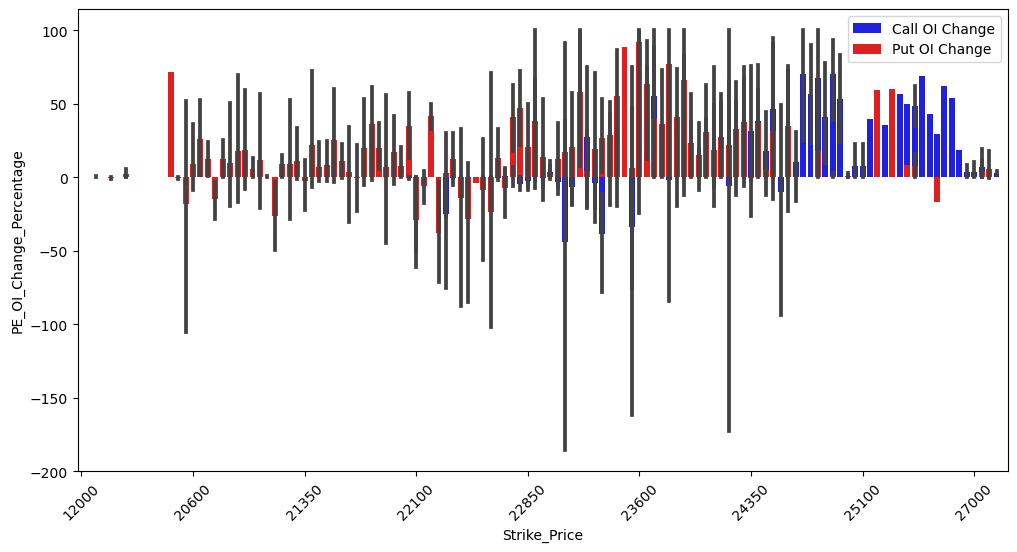

In [337]:
from matplotlib.ticker import MaxNLocator
# Plot OI Change Percentage
plt.figure(figsize=(10, 5))

# Bar plots for Call and Put OI Change Percentage
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Strike_Price", y="CE_OI_Change_Percentage", color="blue", label="Call OI Change", width=0.8)
sns.barplot(data=df, x="Strike_Price", y="PE_OI_Change_Percentage", color="red", label="Put OI Change", width=0.8)
plt.xticks(rotation=45)

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit x-axis to 10 labels

plt.legend()
plt.show()



📌 Interpretation:

If OI rises sharply, the trend is getting stronger.

If OI drops suddenly, beware of trend reversals!

4️⃣ Implied Volatility (IV) Analysis
IV represents market expectations for future volatility.

High IV → Expect major price swings.

Low IV → Market expects stability.

In [341]:
# ✅ Find the Strike Price with the highest & lowest IV
max_iv = df.loc[df["CE_IV"].idxmax(), ["Strike_Price", "CE_IV"]]
min_iv = df.loc[df["CE_IV"].idxmin(), ["Strike_Price", "CE_IV"]]

print("Highest IV Strike Price:", max_iv)
print("Lowest IV Strike Price:", min_iv)


Highest IV Strike Price: Strike_Price    25950
CE_IV           35.53
Name: 780, dtype: object
Lowest IV Strike Price: Strike_Price    12000
CE_IV             0.0
Name: 0, dtype: object


C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nikde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

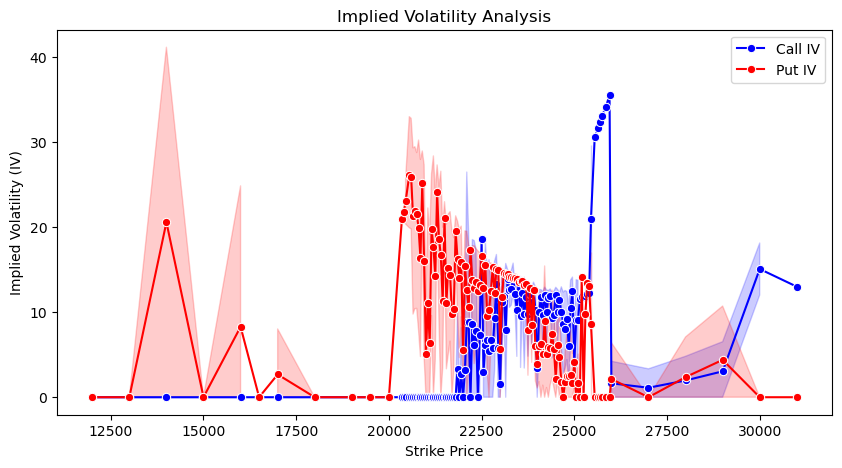

In [343]:
# Implied Volatility (IV) Analysis
plt.figure(figsize=(10,5))
sns.lineplot(x=df['Strike_Price'], y=df['CE_IV'], marker='o', label='Call IV', color='blue')
sns.lineplot(x=df['Strike_Price'], y=df['PE_IV'], marker='o', label='Put IV', color='red')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (IV)")
plt.title("Implied Volatility Analysis")
plt.legend()
plt.show()

📌 Interpretation:

High IV means options are expensive and the market is uncertain.

Low IV means the market expects stability and options are cheaper.


5️⃣ Liquidity Check - Total Traded Volume
Helps find most active strike prices.

In [347]:
# ✅ Find the most traded Strike Prices
most_traded_ce = df.nlargest(5, "CE_Volume")[["Strike_Price", "CE_Volume"]]
most_traded_pe = df.nlargest(5, "PE_Volume")[["Strike_Price", "PE_Volume"]]

print("Most Traded Call Strikes:\n", most_traded_ce)
print("Most Traded Put Strikes:\n", most_traded_pe)


Most Traded Call Strikes:
      Strike_Price  CE_Volume
775         25700    32655.0
772         25550    30802.0
778         25850    26269.0
776         25750    25070.0
606         24150    24726.0
Most Traded Put Strikes:
      Strike_Price  PE_Volume
340         22400     3371.0
547         23800     2234.0
575         24000     2156.0
290         22050     1914.0
263         21900     1862.0


Line Plot of Volume vs. Strike Price
High trading volume indicates better liquidity.

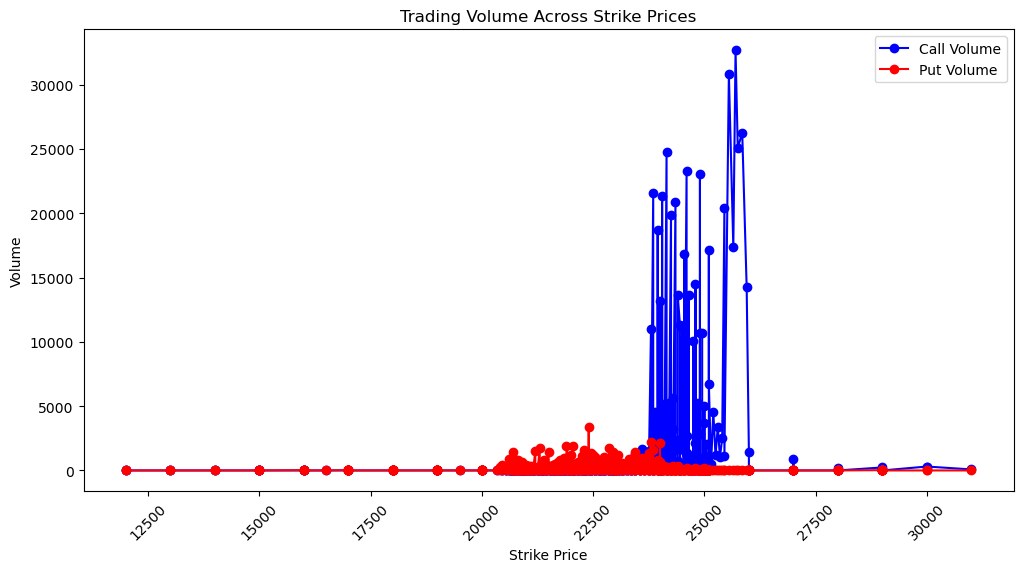

In [351]:
plt.figure(figsize=(12, 6))
plt.plot(df["Strike_Price"], df["CE_Volume"], marker="o", linestyle="-", label="Call Volume", color="blue")
plt.plot(df["Strike_Price"], df["PE_Volume"], marker="o", linestyle="-", label="Put Volume", color="red")
plt.xlabel("Strike Price")
plt.ylabel("Volume")
plt.title("Trading Volume Across Strike Prices")
plt.xticks(rotation=45)
plt.legend()
plt.show()


🔹 Insight: More volume → easier to enter/exit trades.

In [353]:
# Export cleaned data to Excel for Power BI
df.to_excel("option_chain_analysis.xlsx", index=False)

In [355]:
df.head()

,CE_OI,CE_Change_OI,CE_Volume,CE_IV,CE_LTP,Strike_Price,Expiry_date,PE_OI,PE_Change_OI,PE_Volume,PE_IV,PE_LTP,Total_OI,PCR,CE_OI_Change_Percentage,PE_OI_Change_Percentage
0,0.0,0.0,0.0,0.0,0.0,12000,2026-06-25,6.333333,0.0,0.0,0.00,0.00,6.333333,6.333333,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,12000,2026-12-31,13.666667,0.0,0.0,0.00,0.00,13.666667,13.666667,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,13000,2025-12-24,50.000000,0.0,0.0,0.00,0.00,50.000000,50.000000,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,13000,2026-12-31,27.000000,0.0,0.0,0.00,0.00,27.000000,27.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,14000,2025-06-26,110.666667,1.0,4.0,41.19,4.95,110.666667,110.666667,0.0,0.903614
